In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import random
import time

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter


In [3]:
# specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# reproducibility
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



## Data Loading

In [5]:
DIR = os.getcwd()
if DIR.endswith("code"):
    DIR = DIR[:-5]
SAVED_IN = os.path.abspath(DIR + "/models" + "/CNN_complex_fe")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)
print(f"saved in: {SAVED_IN}")

from utils.plot_util import plot_one_gt_train_test, plot_gt_pre_overlap, plot_3_losses
from utils.data_util import (
    dotdict,
    extract_pos_s21_offset,
    load_pos_s21,
    save_pre,
    load_pre,
    PreprocessedDataset,
    get_dataloader,
)
from utils.nn_util import train_NN, count_parameters, count_parameters_table, dict_act
from utils.complex_util import dict_act_complex, complex_normalize, CNN_baseline_complex_fe

saved in: c:\Users\xinch\Desktop\RBI\models\CNN_complex_fe


## Data Extraction

In [6]:
# load data
folder = os.path.join(DIR, "data")
data_file_name = os.path.join(folder, "data_offset_complex.pkl")
pos, s21, pos_TEST, s21_TEST = load_pos_s21(data_file_name, 5)

X = s21
Y = pos

X_TEST = s21_TEST
y_TEST = pos_TEST


## Data Preprocessing

### Train test split wit indicies

In [7]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, indices, test_size=0.2, random_state=RANDOM_STATE
)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(411257, 121)
(411257,)
(102815, 121)
(102815,)


### Normalization

In [8]:
X_train_scaled, X_train_mean, X_train_std = complex_normalize(X_train)
X_test_scaled, X_test_mean, X_test_std = complex_normalize(X_test, X_train_mean, X_train_std)
X_TEST_scaled, X_TEST_mean, X_TEST_std = complex_normalize(X_TEST, X_train_mean, X_train_std)

X_scaled = np.zeros_like(X)
X_scaled[idx_train] = X_train_scaled
X_scaled[idx_test] = X_test_scaled

y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

# add channel dimension for CNN
X_train_scaled = np.expand_dims(X_train_scaled,1)
X_test_scaled = np.expand_dims(X_test_scaled,1)
X_TEST_scaled = np.expand_dims(X_TEST_scaled,1)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
print(X_TEST_scaled.shape)
print(y_TEST.shape)


(411257, 1, 121)
(411257, 1)
(102815, 1, 121)
(102815, 1)
(20135, 1, 121)
(20135, 1)


# CNN concat

## count parameters and macs

In [9]:
# implementation of an equivalent model without complex layers
class CNN_count(nn.Module):
    def __init__(
        self,
        n_features, 
        base_channels,
        activation_fn, 
        device,
        use_fe=False,
        use_dropout=False, 
        use_bn=False
    ):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels =1, out_channels=base_channels, kernel_size=11, stride=5, padding=0)
        self.conv1_ = nn.Conv1d(in_channels =1, out_channels=base_channels, kernel_size=11, stride=5, padding=0)
        self.conv2 = nn.Conv1d(in_channels =base_channels, out_channels=2*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv2_ = nn.Conv1d(in_channels =base_channels, out_channels=2*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels =2*base_channels, out_channels=4*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv3_ = nn.Conv1d(in_channels =2*base_channels, out_channels=4*base_channels, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv1d(in_channels =4*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)
        self.conv4_ = nn.Conv1d(in_channels =4*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)
        self.conv5 = nn.Conv1d(in_channels =8*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)
        self.conv5_ = nn.Conv1d(in_channels =8*base_channels, out_channels=8*base_channels, kernel_size=3, stride=1, padding=0)

        # self.pool = ComplexMaxPool1d(2, 2)

        self.fc = nn.Linear(in_features=1*2*8*base_channels, out_features=1) # TODO, 1 here is derived by the model structure


        self.conv_block1 = self.generate_conv_block(self.conv1, activation_fn, use_dropout, use_bn)
        self.conv_block1_ = self.generate_conv_block(self.conv1_, activation_fn, use_dropout, use_bn)
        self.conv_block2 = self.generate_conv_block(self.conv2, activation_fn, use_dropout, use_bn)
        self.conv_block2_ = self.generate_conv_block(self.conv2_, activation_fn, use_dropout, use_bn)
        self.conv_block3 = self.generate_conv_block(self.conv3, activation_fn, use_dropout, use_bn)
        self.conv_block3_ = self.generate_conv_block(self.conv3_, activation_fn, use_dropout, use_bn)
        self.conv_block4 = self.generate_conv_block(self.conv4, activation_fn, use_dropout, use_bn)
        self.conv_block4_ = self.generate_conv_block(self.conv4_, activation_fn, use_dropout, use_bn)
        self.conv_block5 = self.generate_conv_block(self.conv5, activation_fn, use_dropout, use_bn)
        self.conv_block5_ = self.generate_conv_block(self.conv5_, activation_fn, use_dropout, use_bn)


        # frequency encoding
        self.use_fe = use_fe
        self.n_features = n_features
        self.device = device
        self.weight = nn.Parameter(torch.randn(n_features)[None, :].unsqueeze(1))

    def generate_conv_block(self, conv,activation_fn, use_dropout, use_bn):
        """conv-bn-activation-dropout"""
        layers = []
        layers.append(conv) 
        if use_bn:
            layers.append(nn.BatchNorm1d(conv.out_channels))
        layers.append(activation_fn)
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def frequency_encoding(self, n_features):
        # freq range from 3e8 to 15e8 in real world
        arr_freq = np.arange(0, n_features // 2) * 0.1 + 3
        # normalize to [0,1]
        arr_freq_norm = arr_freq / arr_freq[-1]
        arr_freq_norm = arr_freq_norm[np.newaxis, :].repeat(2, axis=1)
        return torch.Tensor(arr_freq_norm).to(self.device)
    
    def apply_complex(self, fr, fi, x, x_):
        return fr(x) - fi(x_), fr(x_) + fi(x)

    def forward(self, x):
        # frequency encoding
        if self.use_fe:
            arr_freq_norm = self.frequency_encoding(self.n_features)
            x += self.weight * arr_freq_norm
        x, x_ = torch.split(x, 121, dim=-1)
        x, x_ = self.apply_complex(self.conv_block1, self.conv_block1_, x, x_)
        x, x_ = self.apply_complex(self.conv_block2, self.conv_block2_, x, x_)
        x, x_ = self.apply_complex(self.conv_block3, self.conv_block3_, x, x_)
        x, x_ = self.apply_complex(self.conv_block4, self.conv_block4_, x, x_)
        x, x_ = self.apply_complex(self.conv_block5, self.conv_block5_, x, x_)
        
        x = torch.flatten(torch.cat((x,x_),dim=-1),1)
        x = self.fc(x)
        return x

In [11]:
# config_counturation
_config_count = {
    "n_features": 242,
    "base_channels": 4,
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_fe": True,
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config_count = dotdict(_config_count)

# ## define the model

model_count = CNN_count(
    n_features=config_count.n_features,
    base_channels=config_count.base_channels,
    device=device,
    activation_fn=dict_act[config_count.activation],
    use_fe=config_count.use_fe,
    use_dropout=config_count.use_dropout,
    use_bn=config_count.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model_count)


10755

## base channel 4

### Init

In [ ]:
# configuration
_config = {
    "n_features": 121,
    "base_channels": 4,
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_fe": True,
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

# ## define the model
MODEL_NAME = "cnn_baseline.pth"
model = CNN_baseline_complex_fe(
    n_features=config.n_features,
    base_channels=config.base_channels,
    device=device,
    activation_fn=dict_act_complex[config.activation],
    use_fe=config.use_fe,
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
).to(device)
# summary(model, input_size=(1, 242)) # somethings wrong with this
count_parameters(model)


10634

In [ ]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [ ]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [ ]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [ ]:
t1 = time.perf_counter()
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
    save=False
)
t2 = time.perf_counter()
print(f"Training time: {t2-t1:0.4f} seconds")


  0%|          | 0/500 [00:00<?, ?it/s]

[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())


epoch : 0, train loss : 965.46, test loss : 859.71, TEST loss : 854.41, lr: 0.0010
epoch : 10, train loss : 42.32, test loss : 27.91, TEST loss : 28.24, lr: 0.0010
epoch : 20, train loss : 5.81, test loss : 5.35, TEST loss : 6.84, lr: 0.0010
epoch : 30, train loss : 3.37, test loss : 2.94, TEST loss : 3.41, lr: 0.0010
epoch : 40, train loss : 2.15, test loss : 1.84, TEST loss : 2.22, lr: 0.0010
epoch : 50, train loss : 1.65, test loss : 2.05, TEST loss : 2.29, lr: 0.0010
epoch : 60, train loss : 1.42, test loss : 1.43, TEST loss : 1.72, lr: 0.0010
epoch : 70, train loss : 1.28, test loss : 1.11, TEST loss : 1.39, lr: 0.0010
epoch : 80, train loss : 1.20, test loss : 1.33, TEST loss : 1.57, lr: 0.0010
epoch : 90, train loss : 1.13, test loss : 1.41, TEST loss : 1.62, lr: 0.0010
epoch : 100, train loss : 1.09, test loss : 1.22, TEST loss : 1.39, lr: 0.0010
Early stopping triggered
The minimal test loss is 0.94 from epoch 84
Training time: 7966.4228 seconds


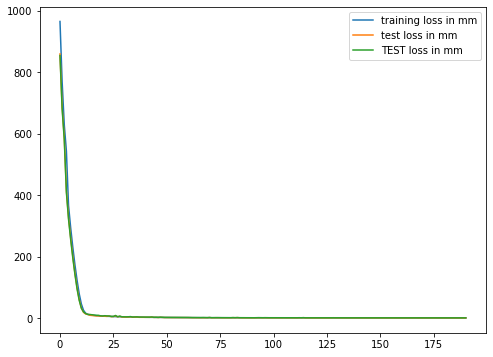

In [ ]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [ ]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


CNN_baseline_complex_fe(
  (conv1): ComplexConv1d(
    (conv_r): Conv1d(1, 4, kernel_size=(11,), stride=(5,))
    (conv_i): Conv1d(1, 4, kernel_size=(11,), stride=(5,))
  )
  (conv2): ComplexConv1d(
    (conv_r): Conv1d(4, 8, kernel_size=(3,), stride=(2,))
    (conv_i): Conv1d(4, 8, kernel_size=(3,), stride=(2,))
  )
  (conv3): ComplexConv1d(
    (conv_r): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
    (conv_i): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
  )
  (conv4): ComplexConv1d(
    (conv_r): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (conv_i): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  )
  (conv5): ComplexConv1d(
    (conv_r): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv_i): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (conv_block1): Sequential(
    (0): ComplexConv1d(
      (conv_r): Conv1d(1, 4, kernel_size=(11,), stride=(5,))
      (conv_i): Conv1d(1, 4, kernel_size=(11,), stride=(5,))


In [ ]:
# evaluation on  training, test and TEST set on 3080


with torch.no_grad():
    y_ = model(torch.from_numpy(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

train RMSE: 0.73 mm
test RMSE: 0.73 mm
TEST RMSE: 1.02 mm


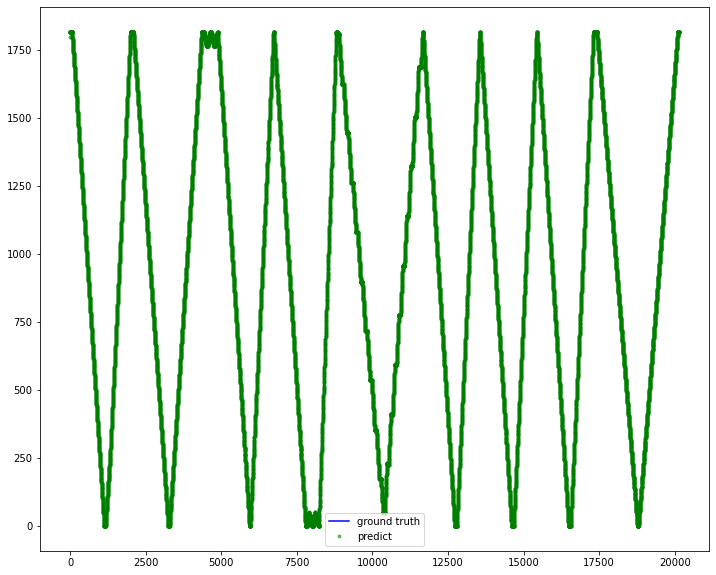

In [ ]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


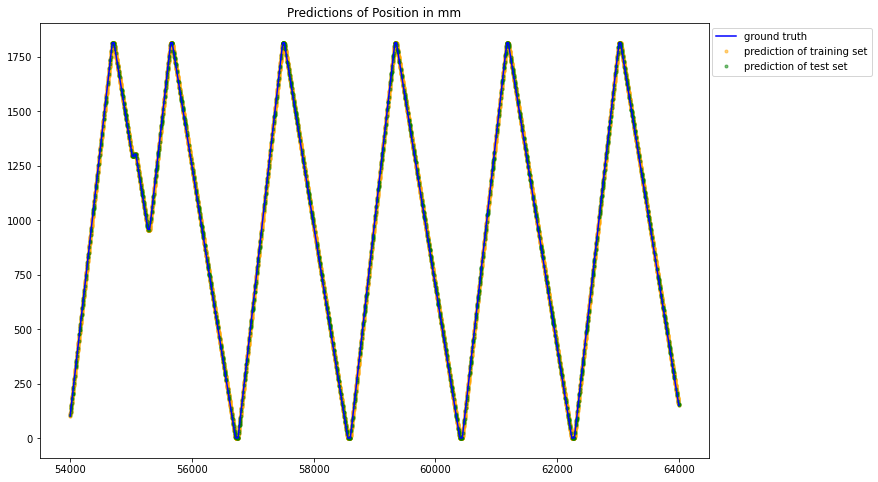

In [ ]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## KFold training

In [ ]:
# configuration
_config = {
    "n_features": 121,
    "base_channels": 4,
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),  # default value
    "use_fe": True,
    "use_dropout": False,
    "use_bn": False,
}
# dot access
config = dotdict(_config)

## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )

### First run

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
RMSE_test = []
RMSE_train = []
RMSE_TEST = []
MODEL_NAME = 'kfold.pth'
for i, (idx_train, idx_test) in enumerate(kf.split(X)):
    X_train = X[idx_train]
    X_test = X[idx_test]
    # norm
    X_train_scaled, X_train_mean, X_train_std = complex_normalize(X_train)
    X_test_scaled, X_test_mean, X_test_std = complex_normalize(X_test, X_train_mean, X_train_std)
    X_TEST_scaled, X_TEST_mean, X_TEST_std = complex_normalize(X_TEST, X_train_mean, X_train_std)

    X_scaled = np.zeros_like(X)
    X_scaled[idx_train] = X_train_scaled
    X_scaled[idx_test] = X_test_scaled

    y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
    y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
    y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

    # add channel dimension for CNN
    X_train_scaled = np.expand_dims(X_train_scaled,1)
    X_test_scaled = np.expand_dims(X_test_scaled,1)
    X_TEST_scaled = np.expand_dims(X_TEST_scaled,1)

    ## define the Dataloaders
    train_dataloader = get_dataloader(
        is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
    )
    test_dataloader = get_dataloader(
        is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
    )
    TEST_dataloader = get_dataloader(
        is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
    )

    # define the model
    model = CNN_baseline_complex_fe(
        n_features=config.n_features,
        base_channels=config.base_channels,
        device=device,
        activation_fn=dict_act_complex[config.activation],
        use_fe=config.use_fe,
        use_dropout=config.use_dropout,
        use_bn=config.use_bn,
    )
    model.to(device).apply(weights_init)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        betas=config.betas,
        weight_decay=config.weight_decay,
    ) 
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    loss_fn = nn.MSELoss()
    # training
    print(f"\nTraining fold {i+1}/{kf.n_splits}...")
    t1 = time.perf_counter()
    best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
        model,
        config,
        loss_fn,
        optimizer,
        scheduler,
        train_dataloader,
        test_dataloader,
        TEST_dataloader,
        device,
        SAVED_IN,
        MODEL_NAME,
        writer=SummaryWriter(),
        save=False
    )
    t2 = time.perf_counter()
    print(f"Training time: {t2-t1:0.4f} seconds")

    # evaluation
    print(f"\nEvaluating fold {i+1}/{kf.n_splits}...")
    # evaluation on  training, test and TEST set on 3080
    with torch.no_grad():
        y_ = model(torch.from_numpy(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
        y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
    y_train_ = y_[idx_train]
    y_test_ = y_[idx_test]

    RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
    RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
    RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

    RMSE_test.append(RMSE_test_final_mm)
    RMSE_train.append(RMSE_train_final_mm)
    RMSE_TEST.append(RMSE_TEST_final_mm)

    print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
    print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
    print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")




Training fold 1/5...


  0%|          | 0/500 [00:00<?, ?it/s]

[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())


epoch : 0, train loss : 965.52, test loss : 859.10, TEST loss : 854.36, lr: 0.0010
epoch : 10, train loss : 47.93, test loss : 30.57, TEST loss : 28.94, lr: 0.0010
epoch : 20, train loss : 4.00, test loss : 3.51, TEST loss : 4.94, lr: 0.0010
epoch : 30, train loss : 2.28, test loss : 2.15, TEST loss : 3.48, lr: 0.0010
epoch : 40, train loss : 1.72, test loss : 1.66, TEST loss : 2.88, lr: 0.0010
epoch : 50, train loss : 1.44, test loss : 1.48, TEST loss : 2.11, lr: 0.0010
epoch : 60, train loss : 1.29, test loss : 1.33, TEST loss : 2.05, lr: 0.0010
epoch : 70, train loss : 1.21, test loss : 1.25, TEST loss : 1.80, lr: 0.0010
epoch : 80, train loss : 1.15, test loss : 1.15, TEST loss : 1.67, lr: 0.0010
epoch : 90, train loss : 1.09, test loss : 1.29, TEST loss : 1.70, lr: 0.0010
epoch : 100, train loss : 1.05, test loss : 1.13, TEST loss : 1.51, lr: 0.0010
epoch : 110, train loss : 1.01, test loss : 0.88, TEST loss : 1.34, lr: 0.0010
Early stopping triggered
The minimal test loss is 0.82

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 970.06, test loss : 865.75, TEST loss : 860.51, lr: 0.0010
epoch : 10, train loss : 78.89, test loss : 60.09, TEST loss : 57.67, lr: 0.0010
epoch : 20, train loss : 6.34, test loss : 5.94, TEST loss : 6.96, lr: 0.0010
epoch : 30, train loss : 3.38, test loss : 3.18, TEST loss : 3.69, lr: 0.0010
epoch : 40, train loss : 2.36, test loss : 2.07, TEST loss : 2.40, lr: 0.0010
epoch : 50, train loss : 1.88, test loss : 1.74, TEST loss : 2.00, lr: 0.0010
epoch : 60, train loss : 1.59, test loss : 1.57, TEST loss : 1.84, lr: 0.0010
epoch : 70, train loss : 1.41, test loss : 1.50, TEST loss : 1.66, lr: 0.0010
epoch : 80, train loss : 1.29, test loss : 1.20, TEST loss : 1.43, lr: 0.0010
epoch : 90, train loss : 1.22, test loss : 1.64, TEST loss : 1.78, lr: 0.0010
epoch : 100, train loss : 1.16, test loss : 1.00, TEST loss : 1.17, lr: 0.0010
epoch : 110, train loss : 1.11, test loss : 1.15, TEST loss : 1.28, lr: 0.0010
epoch : 120, train loss : 1.07, test loss : 0.96, TEST

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 974.17, test loss : 871.80, TEST loss : 868.31, lr: 0.0010
epoch : 10, train loss : 103.59, test loss : 80.71, TEST loss : 77.87, lr: 0.0010
epoch : 20, train loss : 7.18, test loss : 7.02, TEST loss : 8.96, lr: 0.0010
epoch : 30, train loss : 4.11, test loss : 3.88, TEST loss : 4.53, lr: 0.0010
epoch : 40, train loss : 2.76, test loss : 2.52, TEST loss : 3.10, lr: 0.0010
epoch : 50, train loss : 2.03, test loss : 1.85, TEST loss : 2.48, lr: 0.0010
epoch : 60, train loss : 1.65, test loss : 1.49, TEST loss : 2.03, lr: 0.0010
epoch : 70, train loss : 1.42, test loss : 1.33, TEST loss : 1.81, lr: 0.0010
epoch : 80, train loss : 1.28, test loss : 1.26, TEST loss : 1.71, lr: 0.0010
epoch : 90, train loss : 1.19, test loss : 1.11, TEST loss : 1.51, lr: 0.0010
epoch : 100, train loss : 1.11, test loss : 1.14, TEST loss : 1.42, lr: 0.0010
epoch : 110, train loss : 1.05, test loss : 1.03, TEST loss : 1.32, lr: 0.0010
epoch : 120, train loss : 0.98, test loss : 1.02, TES

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 971.66, test loss : 873.01, TEST loss : 866.17, lr: 0.0010
epoch : 10, train loss : 54.14, test loss : 38.58, TEST loss : 37.11, lr: 0.0010
epoch : 20, train loss : 8.95, test loss : 8.01, TEST loss : 11.19, lr: 0.0010
epoch : 30, train loss : 6.17, test loss : 5.59, TEST loss : 7.81, lr: 0.0010
epoch : 40, train loss : 4.51, test loss : 5.22, TEST loss : 5.76, lr: 0.0010
epoch : 50, train loss : 3.40, test loss : 3.59, TEST loss : 4.75, lr: 0.0010
epoch : 60, train loss : 2.67, test loss : 2.86, TEST loss : 3.59, lr: 0.0010
epoch : 70, train loss : 2.19, test loss : 2.05, TEST loss : 2.96, lr: 0.0010
epoch : 80, train loss : 1.83, test loss : 1.83, TEST loss : 2.45, lr: 0.0010
epoch : 90, train loss : 1.62, test loss : 1.37, TEST loss : 2.06, lr: 0.0010
epoch : 100, train loss : 1.48, test loss : 1.73, TEST loss : 2.13, lr: 0.0010
epoch : 110, train loss : 1.36, test loss : 1.28, TEST loss : 1.95, lr: 0.0010
epoch : 120, train loss : 1.26, test loss : 1.21, TES

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 976.21, test loss : 873.89, TEST loss : 871.86, lr: 0.0010
epoch : 10, train loss : 7.33, test loss : 6.61, TEST loss : 6.99, lr: 0.0010
epoch : 20, train loss : 2.72, test loss : 2.84, TEST loss : 2.77, lr: 0.0010
epoch : 30, train loss : 1.72, test loss : 1.84, TEST loss : 1.91, lr: 0.0010
epoch : 40, train loss : 1.35, test loss : 1.49, TEST loss : 1.63, lr: 0.0010
epoch : 50, train loss : 1.15, test loss : 1.11, TEST loss : 1.25, lr: 0.0010
epoch : 60, train loss : 1.04, test loss : 1.02, TEST loss : 1.16, lr: 0.0010
epoch : 70, train loss : 0.96, test loss : 0.96, TEST loss : 1.13, lr: 0.0010
epoch : 80, train loss : 0.90, test loss : 1.02, TEST loss : 1.25, lr: 0.0010
epoch : 90, train loss : 0.86, test loss : 0.91, TEST loss : 1.05, lr: 0.0010
epoch : 100, train loss : 0.82, test loss : 0.82, TEST loss : 1.00, lr: 0.0010
epoch : 110, train loss : 0.79, test loss : 0.75, TEST loss : 0.91, lr: 0.0010
epoch : 120, train loss : 0.75, test loss : 0.80, TEST lo

In [ ]:
RMSE_test, RMSE_train, RMSE_TEST

([0.96706164, 1.0981294, 0.6026267, 0.733786, 0.59171057],
 [0.964293, 1.0954883, 0.60117716, 0.72439915, 0.5887938],
 [1.4447399, 1.2841794, 1.0943613, 1.1971897, 0.7788998])

### Second run

In [30]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
RMSE_test = []
RMSE_train = []
RMSE_TEST = []
MODEL_NAME = 'kfold.pth'
for i, (idx_train, idx_test) in enumerate(kf.split(X)):
    X_train = X[idx_train]
    X_test = X[idx_test]
    # norm
    X_train_scaled, X_train_mean, X_train_std = complex_normalize(X_train)
    X_test_scaled, X_test_mean, X_test_std = complex_normalize(X_test, X_train_mean, X_train_std)
    X_TEST_scaled, X_TEST_mean, X_TEST_std = complex_normalize(X_TEST, X_train_mean, X_train_std)

    X_scaled = np.zeros_like(X)
    X_scaled[idx_train] = X_train_scaled
    X_scaled[idx_test] = X_test_scaled

    y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
    y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
    y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

    # add channel dimension for CNN
    X_train_scaled = np.expand_dims(X_train_scaled,1)
    X_test_scaled = np.expand_dims(X_test_scaled,1)
    X_TEST_scaled = np.expand_dims(X_TEST_scaled,1)

    ## define the Dataloaders
    train_dataloader = get_dataloader(
        is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
    )
    test_dataloader = get_dataloader(
        is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
    )
    TEST_dataloader = get_dataloader(
        is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
    )

    # define the model
    model = CNN_baseline_complex_fe(
        n_features=config.n_features,
        base_channels=config.base_channels,
        device=device,
        activation_fn=dict_act_complex[config.activation],
        use_fe=config.use_fe,
        use_dropout=config.use_dropout,
        use_bn=config.use_bn,
    )
    model.to(device).apply(weights_init)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        betas=config.betas,
        weight_decay=config.weight_decay,
    ) 
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    loss_fn = nn.MSELoss()
    # training
    print(f"\nTraining fold {i+1}/{kf.n_splits}...")
    t1 = time.perf_counter()
    best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
        model,
        config,
        loss_fn,
        optimizer,
        scheduler,
        train_dataloader,
        test_dataloader,
        TEST_dataloader,
        device,
        SAVED_IN,
        MODEL_NAME,
        writer=SummaryWriter(),
        save=False
    )
    t2 = time.perf_counter()
    print(f"Training time: {t2-t1:0.4f} seconds")

    # evaluation
    print(f"\nEvaluating fold {i+1}/{kf.n_splits}...")
    # evaluation on  training, test and TEST set on 3080
    with torch.no_grad():
        y_ = model(torch.from_numpy(np.expand_dims(X_scaled,1)).to(device)).cpu().numpy().squeeze()
        y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
    y_train_ = y_[idx_train]
    y_test_ = y_[idx_test]

    RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
    RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
    RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

    RMSE_test.append(RMSE_test_final_mm)
    RMSE_train.append(RMSE_train_final_mm)
    RMSE_TEST.append(RMSE_TEST_final_mm)

    print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
    print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
    print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")




Training fold 1/5...


  0%|          | 0/500 [00:00<?, ?it/s]

[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())


epoch : 0, train loss : 964.59, test loss : 857.00, TEST loss : 852.25, lr: 0.0010
epoch : 10, train loss : 79.14, test loss : 59.84, TEST loss : 60.71, lr: 0.0010
epoch : 20, train loss : 8.85, test loss : 8.31, TEST loss : 11.83, lr: 0.0010
epoch : 30, train loss : 5.29, test loss : 4.74, TEST loss : 7.93, lr: 0.0010
epoch : 40, train loss : 3.79, test loss : 3.20, TEST loss : 5.59, lr: 0.0010
epoch : 50, train loss : 2.90, test loss : 2.61, TEST loss : 3.95, lr: 0.0010
epoch : 60, train loss : 2.37, test loss : 2.15, TEST loss : 3.25, lr: 0.0010
epoch : 70, train loss : 2.05, test loss : 1.98, TEST loss : 2.68, lr: 0.0010
epoch : 80, train loss : 1.83, test loss : 3.71, TEST loss : 4.28, lr: 0.0010
epoch : 90, train loss : 1.67, test loss : 1.76, TEST loss : 2.30, lr: 0.0010
epoch : 100, train loss : 1.53, test loss : 1.35, TEST loss : 1.94, lr: 0.0010
epoch : 110, train loss : 1.41, test loss : 1.28, TEST loss : 1.83, lr: 0.0010
Early stopping triggered
The minimal test loss is 1.1

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 969.31, test loss : 864.66, TEST loss : 859.43, lr: 0.0010
epoch : 10, train loss : 567.57, test loss : 569.02, TEST loss : 562.66, lr: 0.0010
epoch : 20, train loss : 116.01, test loss : 94.23, TEST loss : 91.10, lr: 0.0010
epoch : 30, train loss : 15.41, test loss : 15.31, TEST loss : 19.00, lr: 0.0010
epoch : 40, train loss : 10.40, test loss : 9.48, TEST loss : 12.70, lr: 0.0010
epoch : 50, train loss : 7.39, test loss : 9.48, TEST loss : 11.21, lr: 0.0010
epoch : 60, train loss : 5.36, test loss : 4.76, TEST loss : 6.34, lr: 0.0010
epoch : 70, train loss : 3.86, test loss : 3.60, TEST loss : 6.06, lr: 0.0010
epoch : 80, train loss : 3.66, test loss : 2.68, TEST loss : 3.90, lr: 0.0010
epoch : 90, train loss : 2.88, test loss : 2.56, TEST loss : 3.82, lr: 0.0010
epoch : 100, train loss : 2.39, test loss : 2.15, TEST loss : 3.84, lr: 0.0010
epoch : 110, train loss : 2.13, test loss : 2.03, TEST loss : 4.00, lr: 0.0010
epoch : 120, train loss : 1.80, test loss

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 973.91, test loss : 870.90, TEST loss : 867.41, lr: 0.0010
epoch : 10, train loss : 33.53, test loss : 28.08, TEST loss : 40.96, lr: 0.0010
epoch : 20, train loss : 10.61, test loss : 10.38, TEST loss : 15.34, lr: 0.0010
epoch : 30, train loss : 5.36, test loss : 4.35, TEST loss : 7.64, lr: 0.0010
epoch : 40, train loss : 3.28, test loss : 3.02, TEST loss : 5.13, lr: 0.0010
epoch : 50, train loss : 2.53, test loss : 3.46, TEST loss : 5.85, lr: 0.0010
epoch : 60, train loss : 2.14, test loss : 2.30, TEST loss : 3.29, lr: 0.0010
epoch : 70, train loss : 1.86, test loss : 1.68, TEST loss : 2.89, lr: 0.0010
epoch : 80, train loss : 1.63, test loss : 1.52, TEST loss : 2.61, lr: 0.0010
epoch : 90, train loss : 1.44, test loss : 1.52, TEST loss : 2.25, lr: 0.0010
epoch : 100, train loss : 1.34, test loss : 1.15, TEST loss : 2.00, lr: 0.0010
epoch : 110, train loss : 1.18, test loss : 1.22, TEST loss : 2.02, lr: 0.0010
epoch : 120, train loss : 1.09, test loss : 0.98, T

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 971.31, test loss : 872.77, TEST loss : 865.93, lr: 0.0010
epoch : 10, train loss : 64.29, test loss : 47.67, TEST loss : 50.51, lr: 0.0010
epoch : 20, train loss : 7.44, test loss : 7.90, TEST loss : 9.39, lr: 0.0010
epoch : 30, train loss : 4.48, test loss : 4.08, TEST loss : 6.31, lr: 0.0010
epoch : 40, train loss : 3.19, test loss : 2.87, TEST loss : 4.69, lr: 0.0010
epoch : 50, train loss : 2.44, test loss : 2.24, TEST loss : 3.77, lr: 0.0010
epoch : 60, train loss : 1.99, test loss : 2.10, TEST loss : 3.11, lr: 0.0010
epoch : 70, train loss : 1.64, test loss : 1.61, TEST loss : 2.11, lr: 0.0010
epoch : 80, train loss : 1.44, test loss : 1.20, TEST loss : 1.66, lr: 0.0010
epoch : 90, train loss : 1.29, test loss : 1.43, TEST loss : 1.88, lr: 0.0010
epoch : 100, train loss : 1.20, test loss : 1.22, TEST loss : 1.54, lr: 0.0010
epoch : 110, train loss : 1.12, test loss : 0.93, TEST loss : 1.22, lr: 0.0010
epoch : 120, train loss : 1.06, test loss : 0.88, TEST

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 976.58, test loss : 874.73, TEST loss : 872.71, lr: 0.0010
epoch : 10, train loss : 109.50, test loss : 86.61, TEST loss : 82.72, lr: 0.0010
epoch : 20, train loss : 5.21, test loss : 5.02, TEST loss : 5.23, lr: 0.0010
epoch : 30, train loss : 3.02, test loss : 3.02, TEST loss : 3.36, lr: 0.0010
epoch : 40, train loss : 2.09, test loss : 1.88, TEST loss : 2.22, lr: 0.0010
epoch : 50, train loss : 1.58, test loss : 1.41, TEST loss : 1.73, lr: 0.0010
epoch : 60, train loss : 1.32, test loss : 1.54, TEST loss : 1.78, lr: 0.0010
epoch : 70, train loss : 1.16, test loss : 1.13, TEST loss : 1.31, lr: 0.0010
epoch : 80, train loss : 1.04, test loss : 1.19, TEST loss : 1.41, lr: 0.0010
epoch : 90, train loss : 0.96, test loss : 0.87, TEST loss : 1.10, lr: 0.0010
epoch : 100, train loss : 0.89, test loss : 0.78, TEST loss : 1.00, lr: 0.0010
epoch : 110, train loss : 0.84, test loss : 0.85, TEST loss : 1.03, lr: 0.0010
epoch : 120, train loss : 0.78, test loss : 0.73, TES

In [31]:
RMSE_test, RMSE_train, RMSE_TEST

([1.5655491, 1.5782703, 0.5540158, 0.8140413, 0.65457433],
 [1.5664781, 1.5721391, 0.5555318, 0.8087055, 0.65214205],
 [2.0374846, 3.6256301, 1.1144555, 1.0646452, 0.84073764])